In [1]:
import tensorflow as tf
import pandas as pd

# Download MovieLens dataset
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"   #la versione ridotta
zip_file = tf.keras.utils.get_file("ml-latest-small.zip", url, extract=True, cache_dir='./')
extracted_folder = zip_file.replace('.zip', '')

# Load ratings data into a Pandas DataFrame
ratings_file = extracted_folder + '/ratings.csv'
ratings_df = pd.read_csv(ratings_file)

# Display the first 10 rows
print("First 10 rows:")
print(ratings_df.head(10))

# Display the last 10 rows
print("\nLast 10 rows:")
print(ratings_df.tail(10))


First 10 rows:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100

Last 10 rows:
        userId  movieId  rating   timestamp
100826     610   162350     3.5  1493849971
100827     610   163937     3.5  1493848789
100828     610   163981     3.5  1493850155
100829     610   164179     5.0  1493845631
100830     610   166528     4.0  1493879365
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415


In [2]:
dataset = ratings_df
type(dataset)

pandas.core.frame.DataFrame

In [3]:
dataset.shape

(100836, 4)

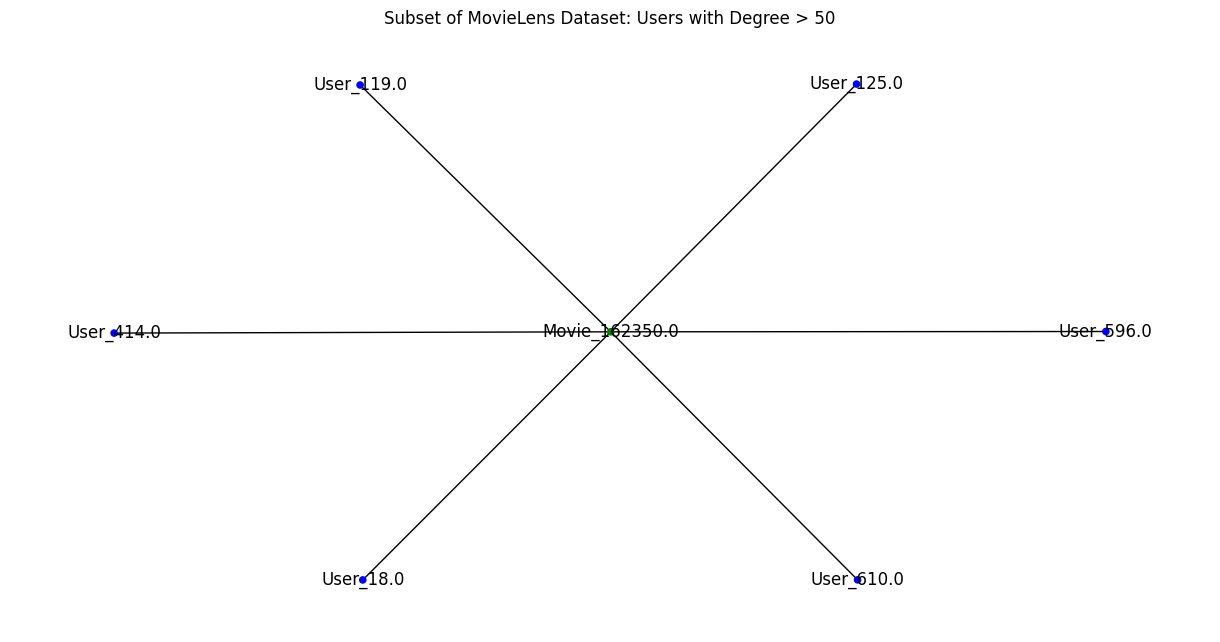

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes (users and movies) and edges (interactions)
for _, row in dataset.iterrows():
    user_id = f"User_{row['userId']}"
    movie_id = f"Movie_{row['movieId']}"

    G.add_node(user_id, bipartite=0)
    G.add_node(movie_id, bipartite=1)
    G.add_edge(user_id, movie_id)

# Filter nodes based on user degree
user_nodes = [node for node in G.nodes if "Movie_162350" in node]

# Create a subgraph with filtered nodes
filtered_nodes = user_nodes + list(set(neighbor for node in user_nodes for neighbor in G.neighbors(node)))
filtered_G = G.subgraph(filtered_nodes)

# Visualize the subgraph
pos = nx.spring_layout(filtered_G)
colors = ["blue" if "User_" in node else "green" for node in filtered_G.nodes]

plt.figure(figsize=(12, 6))
nx.draw(filtered_G, pos, with_labels=True, node_color=colors, node_size=20)
plt.title("Subset of MovieLens Dataset: Users with Degree > 50")
plt.show()

In [5]:
print(G.nodes)

['User_1.0', 'Movie_1.0', 'Movie_3.0', 'Movie_6.0', 'Movie_47.0', 'Movie_50.0', 'Movie_70.0', 'Movie_101.0', 'Movie_110.0', 'Movie_151.0', 'Movie_157.0', 'Movie_163.0', 'Movie_216.0', 'Movie_223.0', 'Movie_231.0', 'Movie_235.0', 'Movie_260.0', 'Movie_296.0', 'Movie_316.0', 'Movie_333.0', 'Movie_349.0', 'Movie_356.0', 'Movie_362.0', 'Movie_367.0', 'Movie_423.0', 'Movie_441.0', 'Movie_457.0', 'Movie_480.0', 'Movie_500.0', 'Movie_527.0', 'Movie_543.0', 'Movie_552.0', 'Movie_553.0', 'Movie_590.0', 'Movie_592.0', 'Movie_593.0', 'Movie_596.0', 'Movie_608.0', 'Movie_648.0', 'Movie_661.0', 'Movie_673.0', 'Movie_733.0', 'Movie_736.0', 'Movie_780.0', 'Movie_804.0', 'Movie_919.0', 'Movie_923.0', 'Movie_940.0', 'Movie_943.0', 'Movie_954.0', 'Movie_1009.0', 'Movie_1023.0', 'Movie_1024.0', 'Movie_1025.0', 'Movie_1029.0', 'Movie_1030.0', 'Movie_1031.0', 'Movie_1032.0', 'Movie_1042.0', 'Movie_1049.0', 'Movie_1060.0', 'Movie_1073.0', 'Movie_1080.0', 'Movie_1089.0', 'Movie_1090.0', 'Movie_1092.0', 'Movi

In [89]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import spektral
from spektral.layers import GraphSageConv
from scipy.sparse import coo_matrix


# Create user and movie mappings
user_mapping = {user: idx for idx, user in enumerate(ratings_df['userId'].unique())}
movie_mapping = {movie: idx for idx, movie in enumerate(ratings_df['movieId'].unique())}

# Add user and movie indices to the DataFrame
ratings_df['user_idx'] = ratings_df['userId'].map(user_mapping)
ratings_df['movie_idx'] = ratings_df['movieId'].map(movie_mapping)

# Split the data into train and test sets
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Create adjacency matrix
num_users = len(user_mapping)
num_movies = len(movie_mapping)
adjacency_matrix = np.zeros((num_users, num_users))
adjacency_matrix[train_df['user_idx'], train_df['user_idx']] = 1.0
# Convert to a sparse matrix
adjacency_sparse = coo_matrix(adjacency_matrix)


# Define the GNN model
class MovieRecommendationGNN(Model):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(MovieRecommendationGNN, self).__init__()

        self.user_embedding = layers.Embedding(num_users, embedding_dim)
        self.movie_embedding = layers.Embedding(num_movies, embedding_dim)

        self.graph_sage_conv = GraphSageConv(channels=embedding_dim, aggregate='mean', activation='relu')

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation='linear')

    def call(self, inputs):
        user_idx, movie_idx = inputs

        user_embedding = self.user_embedding(user_idx)
        movie_embedding = self.movie_embedding(movie_idx)

        print("A")
        x = tf.concat([user_embedding, movie_embedding], axis=-1)

        print("B")
        # Assuming you have an adjacency matrix
        adjacency_tensor = spektral.utils.normalized_adjacency(adjacency_sparse)
        print("user_embedding shape:", user_embedding.shape)
        print("movie_embedding shape:", movie_embedding.shape)
        print("x shape:", x.shape)
        print("adjacency_tensor shape:", adjacency_tensor.shape)
        
        x = self.graph_sage_conv([x, adjacency_tensor])

        x = self.flatten(x)
        x = self.dense(x)

        return x

# Instantiate the GNN model
embedding_dim = 32
gnn_model = MovieRecommendationGNN(num_users=num_users, num_movies=num_movies, embedding_dim=embedding_dim)

# Compile the model
gnn_model.compile(optimizer='adam', loss='mse')

# Train the model
train_inputs = [train_df['user_idx'].values, train_df['movie_idx'].values]
train_labels = train_df['rating'].values.astype(np.float32)
print("Prima del fit")
gnn_model.fit(train_inputs, train_labels, epochs=5, batch_size=64, validation_split=0.2)
print("Dopo del fit")

# Evaluate the model on the test set
test_inputs = [test_df['user_idx'].values, test_df['movie_idx'].values]
test_labels = test_df['rating'].values.astype(np.float32)
test_loss = gnn_model.evaluate(test_inputs, test_labels)
print(f'Test Loss: {test_loss}')

test_loss = gnn_model.evaluate(test_inputs, test_labels)
print(f'Test Loss: {test_loss}')

# Make predictions for a user (replace 'user_idx' with the actual user index)
user_id = 8
user_idx = user_mapping[user_id]
movie_idx = np.array(list(movie_mapping.values()))
user_inputs = [np.array([user_idx]), movie_idx]
user_ratings = gnn_model.predict(user_inputs).flatten()

# Get top N recommended movies
top_n_movies = np.argsort(user_ratings)[::-1][:10]

# Display the top recommended movies
movie_titles = ratings_df[ratings_df['movie_idx'].isin(top_n_movies)]['movieId'].unique()
print(f"Top 10 recommended movies for user {user_id}: {movie_titles}")


Prima del fit
Epoch 1/5
A
B
user_embedding shape: (None, 32)
movie_embedding shape: (None, 32)
x shape: (None, 64)
adjacency_tensor shape: (610, 610)


AssertionError: in user code:

    File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\david\AppData\Local\Temp\__autograph_generated_filel2sgqkmy.py", line 21, in tf__call
        x = ag__.converted_call(ag__.ld(self).graph_sage_conv, ([ag__.ld(x), ag__.ld(adjacency_tensor)],), None, fscope)
    File "C:\Users\david\AppData\Local\Temp\__autograph_generated_file1kinu3cm.py", line 10, in tf__call
        (x, a, _) = ag__.converted_call(ag__.ld(self).get_inputs, (ag__.ld(inputs),), None, fscope)
    File "C:\Users\david\AppData\Local\Temp\__autograph_generated_filenzovr3vp.py", line 55, in tf__get_inputs
        assert ag__.converted_call(ag__.ld(K).is_sparse, (ag__.ld(a),), None, fscope), 'A must be a SparseTensor'

    AssertionError: Exception encountered when calling layer 'movie_recommendation_gnn_59' (type MovieRecommendationGNN).
    
    in user code:
    
        File "C:\Users\david\AppData\Local\Temp\ipykernel_10020\3430249814.py", line 58, in call  *
            x = self.graph_sage_conv([x, adjacency_tensor])
        File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\david\AppData\Local\Temp\__autograph_generated_file1kinu3cm.py", line 10, in tf__call
            (x, a, _) = ag__.converted_call(ag__.ld(self).get_inputs, (ag__.ld(inputs),), None, fscope)
        File "C:\Users\david\AppData\Local\Temp\__autograph_generated_filenzovr3vp.py", line 55, in tf__get_inputs
            assert ag__.converted_call(ag__.ld(K).is_sparse, (ag__.ld(a),), None, fscope), 'A must be a SparseTensor'
    
        AssertionError: Exception encountered when calling layer 'graph_sage_conv_15' (type GraphSageConv).
        
        in user code:
        
            File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\spektral\layers\convolutional\graphsage_conv.py", line 105, in call  *
                x, a, _ = self.get_inputs(inputs)
            File "c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\spektral\layers\convolutional\message_passing.py", line 183, in get_inputs  *
                assert K.is_sparse(a), "A must be a SparseTensor"
        
            AssertionError: A must be a SparseTensor
        
        
        Call arguments received by layer 'graph_sage_conv_15' (type GraphSageConv):
          • inputs=['tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(610, 610), dtype=float32)']
    
    
    Call arguments received by layer 'movie_recommendation_gnn_59' (type MovieRecommendationGNN):
      • inputs=('tf.Tensor(shape=(None,), dtype=int64)', 'tf.Tensor(shape=(None,), dtype=int64)')


In [36]:
print(len(user_mapping))
print(len(movie_mapping))

610
9724
